In [11]:
import sys
import math
import re
from datetime import datetime
from pathlib import Path
from joblib import Parallel, delayed

import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

sys.path.append(str(Path("..").resolve()))
from hyper_rbm import load_model

models_dir = Path("models")
results_dir = Path("results")
results_dir.mkdir(parents=True, exist_ok=True)

device = "cpu"
print(f"Running on: {device}")
print(f"Looking for models in: {models_dir}")

Running on: cpu
Looking for models in: models


In [12]:
@torch.no_grad()
def compute_renyi_entropy(samples: torch.Tensor, subs_size: int, log_score_fn: callable) -> float:
    """
    Computes Renyi Entropy S2 using the swap operator on two replicas.
    Returns only the entropy value (no Monte Carlo error estimate).
    """
    n_samples = samples.shape[0]
    half = n_samples // 2

    if half == 0:
        return float("nan")

    # split up samples into two replicas and score them
    ref_1 = samples[:half]
    ref_2 = samples[half:2 * half]
    ref_score_1 = log_score_fn(ref_1)
    ref_score_2 = log_score_fn(ref_2)

    # find indices for slicing
    slice_idx = torch.arange(subs_size, samples.shape[1], device=samples.device)

    # recombine into swapped samples and score them
    swap_1 = ref_1.clone()
    swap_1[:, slice_idx] = ref_2[:, slice_idx]
    swap_2 = ref_2.clone()
    swap_2[:, slice_idx] = ref_1[:, slice_idx]
    swap_score_1 = log_score_fn(swap_1)
    swap_score_2 = log_score_fn(swap_2)

    # calculate swap ratio in log-space
    log_ratios = (swap_score_1 + swap_score_2) - (ref_score_1 + ref_score_2)

    N = log_ratios.numel()

    # renyi entropy as -log(mean(Ratio))
    # log_sum_exp trick for stability: log(sum(exp(x))) - log(N)
    log_mean_r = torch.logsumexp(log_ratios, dim=0) - math.log(N)
    renyi_entropy = -log_mean_r.item()

    return renyi_entropy

In [13]:
def evaluate_model_file(model_path: Path):
    # Configuration
    SEED = 42
    K_STEPS = 20
    TOTAL_SAMPLES = 100_000
    DENSE_RES = 0.05

    print(f"Processing: {model_path.name}")

    # Load Model
    from hyper_rbm import load_model
    model, config = load_model(model_path, device)

    # Extract info from filename/config
    match = re.search(r"seed(\d+)", model_path.name)
    seed_idx = int(match.group(1)) if match else 0

    # Extract timestamp or generate new one
    ts_match = re.search(r"(\d{8}_\d{6})", model_path.name)
    timestamp = ts_match.group(1) if ts_match else datetime.now().strftime("%Y%m%d_%H%M%S")

    CHAIN_LENGTH = int(model.num_v)
    model_dtype = next(model.parameters()).dtype
    h_support_vals = sorted(config.get("h_support", []))

    # Define h grid (Dense sweep)
    h_novel_vals = np.arange(min(h_support_vals), max(h_support_vals) + 0.01, DENSE_RES)
    h_novel_vals = [h for h in h_novel_vals if not any(np.isclose(h, s, atol=1e-3) for s in h_support_vals)]
    all_h_values = sorted(list(set(h_support_vals) | set(h_novel_vals)))

    l_axis = list(range(1, CHAIN_LENGTH // 2 + 1))
    rng_eval = torch.Generator(device=device).manual_seed(SEED)

    results_list = []

    for h_val in all_h_values:
        split = "support" if any(np.isclose(h_val, s, atol=1e-3) for s in h_support_vals) else "novel"

        # Generate samples
        cond_batch = torch.full((TOTAL_SAMPLES, 1), h_val, device=device, dtype=model_dtype)
        schedule = torch.tensor([1.0] * K_STEPS, device=device, dtype=model_dtype)

        with torch.no_grad():
            samples = model.generate(cond_batch, schedule, rng=rng_eval)

        # Scorer closure
        def scorer(v):
            c = torch.full((v.shape[0], 1), h_val, device=v.device, dtype=v.dtype)
            return model.log_score(v, c)

        # Compute entropy for all l
        for l in l_axis:
            s2 = compute_renyi_entropy(samples, l, scorer)
            results_list.append({
                "h": float(h_val),
                "l": int(l),
                "type": split,
                "s2": s2,
                "seed": seed_idx,
                "model_file": model_path.name
            })

        del samples

    # Save individual result file with requested naming scheme
    results_df = pd.DataFrame(results_list)
    # Naming: tfim_16_entangle_rbm_seedX_TIMESTAMP.csv
    save_filename = f"tfim_{CHAIN_LENGTH}_entangle_rbm_seed{seed_idx}_{timestamp}.csv"
    results_df.to_csv(results_dir / save_filename, index=False, float_format="%.6e")

    return results_df

In [14]:
# 1. Define seeds to look for
TARGET_SEEDS = set(range(42, 52)) # Matches the seeds 42..51 from training

# 2. Parse all available files
all_files = list(models_dir.glob("hyprbm_tfim_16_*_seed*.pt"))
parsed_files = []

for p in all_files:
    # Parse seed
    s_match = re.search(r"seed(\d+)", p.name)
    # Parse timestamp (assuming format YYYYMMDD_HHMMSS at end of file)
    t_match = re.search(r"(\d{8}_\d{6})", p.name)

    if s_match and t_match:
        seed = int(s_match.group(1))
        ts = t_match.group(1)
        parsed_files.append({"seed": seed, "ts": ts, "path": p})

# 3. Sort by Timestamp Descending (Newest first)
parsed_files.sort(key=lambda x: x["ts"], reverse=True)

# 4. Select unique seeds found in target set (picking newest due to sort order)
selected_map = {}
for item in parsed_files:
    s = item["seed"]
    if s in TARGET_SEEDS and s not in selected_map:
        selected_map[s] = item["path"]

# Sort final list by seed for clean processing
selected_paths = [selected_map[s] for s in sorted(selected_map.keys())]

print(f"Found {len(selected_map)} models overlapping with specified seed set (newest match only):")
for p in selected_paths:
    print(f"  - {p.name}")

Found 3 models overlapping with specified seed set (newest match only):
  - hyprbm_tfim_16_20000_seed42_20260205_212253.pt
  - hyprbm_tfim_16_20000_seed43_20260205_212254.pt
  - hyprbm_tfim_16_20000_seed44_20260205_212251.pt


In [16]:
results_list = Parallel(n_jobs=4)(delayed(evaluate_model_file)(p) for p in selected_paths)
all_results_df = pd.concat(results_list, ignore_index=True)
print(f"\nEvaluation complete.")


Evaluation complete.


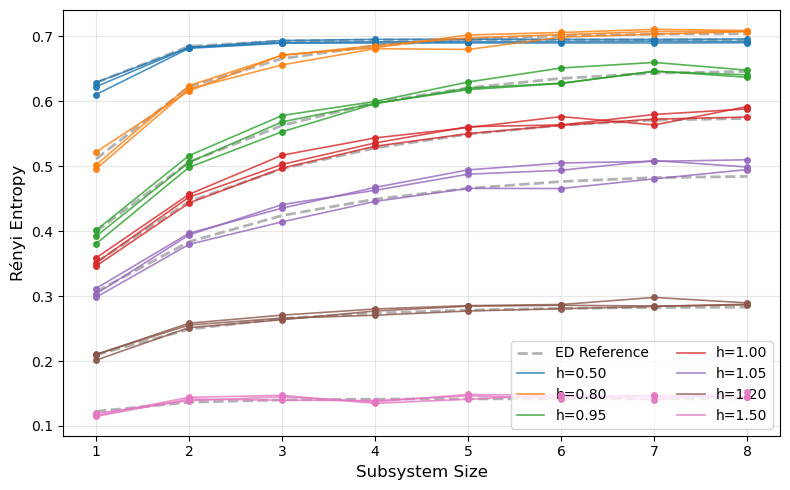

In [20]:
# --- Individual seed traces (support only) ---

SYSTEM_SIZE = 16
ATOL_H = 1e-3

# data for plot
plot_df = all_results_df[all_results_df["type"] == "support"].copy()
h_support_vals = sorted(plot_df["h"].unique())
seeds = sorted(plot_df["seed"].unique())

# reference
ref_file = Path(f"tfim_{SYSTEM_SIZE}_entangle_ref.csv")
ref_df = pd.read_csv(ref_file) if ref_file.exists() else None

def overlay_ed(ax):
    if ref_df is None or not {"h", "l", "s2"}.issubset(ref_df.columns):
        return False

    added = False
    for h in h_support_vals:
        sub = ref_df[np.isclose(ref_df["h"], h, atol=ATOL_H)].sort_values("l")
        if sub.empty:
            continue
        ax.plot(
            sub["l"], sub["s2"],
            "--", color="gray", linewidth=2, alpha=0.6, zorder=0,
            label=("ED Reference" if not added else None),
        )
        added = True
    return added

fig, ax = plt.subplots(figsize=(8, 5), dpi=100)
cmap = plt.get_cmap("tab10")

overlay_ed(ax)

# more opaque than before
alpha_line = 0.80   # was 0.5 in your old code
alpha_marker = 0.90

for j, h in enumerate(h_support_vals):
    color = cmap(j % 10)
    sub_h = plot_df[np.isclose(plot_df["h"], h, atol=ATOL_H)]

    for k, seed in enumerate(seeds):
        sub = sub_h[sub_h["seed"] == seed].sort_values("l")
        if sub.empty:
            continue

        lbl = f"h={h:.2f}" if k == 0 else None

        ax.plot(sub["l"], sub["s2"], "-", color=color, linewidth=1.2, alpha=alpha_line, zorder=5, label=lbl)
        ax.plot(sub["l"], sub["s2"], "o", color=color, markersize=4, alpha=alpha_marker, zorder=6)

ax.set_xlabel(r"Subsystem Size", fontsize=12)
ax.set_ylabel(r"Rényi Entropy", fontsize=12)
ax.grid(True, alpha=0.3)
ax.legend(loc="lower right", ncol=2)
fig.tight_layout()
plt.show()